In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from typing import Union
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

import os 

while "notebooks" in os.getcwd():
    os.chdir("..")

from src.preprocessing.lstm.make_dataset import StockReturnsDataset, \
    StockPricesDataset, get_prices_features, normalize_features,\
    generate_sentiment_features

from src.preprocessing.finbert.get_news import get_news, \
    filter_news_with_name, save_company_news_df,\
    read_company_news_df

# LSTM Analysis with Tech stock prices

## Prices

In [3]:
all_prices = pd.DataFrame([])

In [4]:
prices_df = yf.download(
    tickers= "AAPL",
    start="2020-01-10",
    end="2022-12-30",
)

[*********************100%***********************]  1 of 1 completed


In [6]:
universe = [
    "AMZN", 
    "AAPL", 
    "MSFT", 
    "TSLA",
    "META",
    "NFLX",
    "GOOGL",
    "ORCL",
    "ADBE",
    "NVDA"
]
all_prices = []

for ticker in universe:
    prices_df = yf.download(
        tickers= ticker,
        start="2019-12-30",
        end="2023-08-23",
    )

    all_prices.append(get_prices_features(
        prices_df,
        ticker,
        lookback=10,
        pct_change= False
    ))


all_prices_df = pd.concat(all_prices)

all_prices_df["ticker"] = all_prices_df["ticker"]\
    .replace("META", "FB")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
prices_without_ticker = all_prices_df\
    .loc[:,all_prices_df.columns != 'ticker']

In [8]:
scaler, normalized_prices_df = normalize_features(
    prices_without_ticker
)

In [9]:
normalized_prices_df["ticker"] = all_prices_df["ticker"]

### Obtaining sentiment

In [10]:
universe = [
    "AMZN", 
    "AAPL", 
    "MSFT", 
    "TSLA",
    "FB",
    "NFLX",
    "GOOGL",
    "ORCL",
    "ADBE",
    "NVDA"
]

sentiment_list = []

for ticker in tqdm(universe):
    sentiment = generate_sentiment_features(ticker,
                                            updated= True)
    sentiment["ticker"] = ticker
    sentiment_list.append(sentiment)

sentiment_df = pd.concat(sentiment_list)
sentiment_df.index = pd.to_datetime(sentiment_df.index)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 11.80it/s]


In [11]:
sentiment_df.reset_index(inplace=True)
normalized_prices_df.reset_index(inplace=True)

In [12]:
features_df = pd.merge(
    normalized_prices_df,
    sentiment_df,
    left_on=["ticker", "Date"],
    right_on=["ticker", "date"],
    how = "left"
)\
    .set_index(["Date", "ticker"])

In [13]:
selected_columns = ~((features_df.columns == "index") | (features_df.columns == "date") )

In [14]:
feature_names = [i for i in range(1,10 + 1)]
# feature_names.append("sentiment_count")


In [15]:
train_dates = features_df.index\
    .get_level_values("Date") < '2021-04'

test_dates = features_df.index\
    .get_level_values("Date") > '2021-04'

In [16]:
X_train = features_df\
    .loc[train_dates,selected_columns]\
    .fillna(0)

X_test = features_df\
    .loc[test_dates ,selected_columns]\
    .fillna(0)

In [17]:
y_train = features_df\
    .fillna(0)\
    .loc[train_dates, "price"]

y_test = features_df\
    .loc[test_dates, "price"]

In [18]:
X_train_numpy = X_train\
    .loc[:, feature_names]\
    .to_numpy()\
    .reshape((
        X_train.shape[0],
        X_train.loc[:,feature_names].shape[1],
        1
    ))

X_test_numpy = X_test\
    .loc[:, feature_names]\
    .to_numpy()\
    .reshape((
        X_test.shape[0],
        X_test.loc[:,feature_names].shape[1],
        1
    ))

In [19]:
y_train_numpy = y_train\
    .to_numpy()\
    .reshape(-1,1)

y_test_numpy = y_test\
    .to_numpy()\
    .reshape(-1,1)

In [20]:
X_train_tensor = torch\
    .from_numpy(X_train_numpy)\
    .type(torch.Tensor)

X_test_tensor = torch\
    .from_numpy(X_test_numpy)\
    .type(torch.Tensor)

In [21]:
y_train_tensor = torch\
    .from_numpy(y_train_numpy)\
    .type(torch.Tensor)

y_test_tensor = torch\
    .from_numpy(y_test_numpy)\
    .type(torch.Tensor)

In [22]:
dataset = StockPricesDataset(X_train_tensor, y_train_tensor)

dataloader = DataLoader(
    dataset,
    batch_size= 5,
    shuffle= True,
)

In [23]:
X_train_tensor.size(),\
y_train_tensor.size()

(torch.Size([3060, 10, 1]), torch.Size([3060, 1]))

## Building LSTM model

In [24]:
class LSTM(nn.Module):
    def __init__(self, 
                 input_dim: int, 
                 hidden_dim : int , 
                 num_layers : int , 
                 output_dim : int,
                 activation : callable = lambda x : x 
                ):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_dim, 
            hidden_dim, 
            num_layers, 
            batch_first=True,
        )

        self.activation = activation

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, 
                x: torch.Tensor):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.activation(out)
        out = self.fc(out[:, -1, :]) 
        return out

In [25]:
class GRU(nn.Module):
    def __init__(self, 
                 input_dim : int, 
                 hidden_dim : int, 
                 num_layers : int, 
                 output_dim : int
                ):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(
            input_dim, 
            hidden_dim, 
            num_layers, 
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out


## Neural network training

In [26]:
# lookback = 100
input_dim = 1
hidden_dim = 3
num_layers = 1
output_dim = 1
num_epochs = 50

In [27]:
model = GRU(
    input_dim,
    hidden_dim,
    num_layers,
    output_dim,
)

In [28]:
model.load_state_dict(torch.load("data/models/GRU_trained.pt"))

<All keys matched successfully>

In [29]:
treinable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
treinable_params

58

In [257]:
loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.05)

In [258]:
# hist = np.zeros(num_epochs)

for t in (range(num_epochs)):
    epoch_accuracy = []
    for X, y in tqdm(dataloader):
        y_train_pred = model(X)

        loss = loss_fn(y_train_pred, y)
        
        epoch_accuracy.append(loss.item())
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    with torch.no_grad():
        y_test_pred = model(X_test_tensor)

        loss = loss_fn(y_test_pred, y_test_tensor)

        print(f"Epoch {t+1} error : {np.mean(epoch_accuracy)}")


  0%|          | 0/612 [00:00<?, ?it/s]

100%|██████████| 612/612 [00:02<00:00, 238.75it/s]


Epoch 1 error : 0.0076486330613049465


100%|██████████| 612/612 [00:02<00:00, 246.35it/s]


Epoch 2 error : 0.0008559002964222326


100%|██████████| 612/612 [00:02<00:00, 251.02it/s]


Epoch 3 error : 0.0008135706619561781


100%|██████████| 612/612 [00:02<00:00, 240.85it/s]


Epoch 4 error : 0.0006386394084773177


100%|██████████| 612/612 [00:02<00:00, 243.52it/s]


Epoch 5 error : 0.0004560756117070121


100%|██████████| 612/612 [00:02<00:00, 251.39it/s]


Epoch 6 error : 0.0005434242275538244


100%|██████████| 612/612 [00:02<00:00, 248.10it/s]


Epoch 7 error : 0.00047559640030586333


100%|██████████| 612/612 [00:02<00:00, 250.42it/s]


Epoch 8 error : 0.0004873733098973722


100%|██████████| 612/612 [00:02<00:00, 251.33it/s]


Epoch 9 error : 0.0004568322491118154


100%|██████████| 612/612 [00:02<00:00, 246.72it/s]


Epoch 10 error : 0.000534470064954815


100%|██████████| 612/612 [00:02<00:00, 249.08it/s]


Epoch 11 error : 0.0005086775545243232


100%|██████████| 612/612 [00:02<00:00, 244.70it/s]


Epoch 12 error : 0.0004174715976128057


100%|██████████| 612/612 [00:02<00:00, 252.77it/s]


Epoch 13 error : 0.0004234180535257532


100%|██████████| 612/612 [00:02<00:00, 254.32it/s]


Epoch 14 error : 0.00038457289772945454


100%|██████████| 612/612 [00:02<00:00, 227.93it/s]


Epoch 15 error : 0.00045505914852351543


100%|██████████| 612/612 [00:02<00:00, 247.90it/s]


Epoch 16 error : 0.00048766996272524624


100%|██████████| 612/612 [00:02<00:00, 244.83it/s]


Epoch 17 error : 0.00047127071489618184


100%|██████████| 612/612 [00:02<00:00, 248.30it/s]


Epoch 18 error : 0.000407264494807273


100%|██████████| 612/612 [00:02<00:00, 238.93it/s]


Epoch 19 error : 0.00039456847599211826


100%|██████████| 612/612 [00:02<00:00, 249.08it/s]


Epoch 20 error : 0.00043464205455121354


100%|██████████| 612/612 [00:02<00:00, 245.26it/s]


Epoch 21 error : 0.0004324149289113194


100%|██████████| 612/612 [00:02<00:00, 240.58it/s]


Epoch 22 error : 0.0006133110686271771


100%|██████████| 612/612 [00:02<00:00, 238.26it/s]


Epoch 23 error : 0.0003030641022970408


100%|██████████| 612/612 [00:02<00:00, 248.18it/s]


Epoch 24 error : 0.0005097776021344853


100%|██████████| 612/612 [00:02<00:00, 245.71it/s]


Epoch 25 error : 0.0004014976884703774


100%|██████████| 612/612 [00:02<00:00, 238.73it/s]


Epoch 26 error : 0.00045415625923506846


100%|██████████| 612/612 [00:02<00:00, 214.48it/s]


Epoch 27 error : 0.00030978102623236076


100%|██████████| 612/612 [00:02<00:00, 210.48it/s]


Epoch 28 error : 0.0004536805081521183


100%|██████████| 612/612 [00:02<00:00, 226.21it/s]


Epoch 29 error : 0.00036827890526339223


100%|██████████| 612/612 [00:02<00:00, 224.09it/s]


Epoch 30 error : 0.00040230242858517895


100%|██████████| 612/612 [00:02<00:00, 231.85it/s]


Epoch 31 error : 0.00041459008181082146


100%|██████████| 612/612 [00:02<00:00, 232.38it/s]


Epoch 32 error : 0.00039696284397682484


100%|██████████| 612/612 [00:02<00:00, 245.89it/s]


Epoch 33 error : 0.00038370418147021864


100%|██████████| 612/612 [00:02<00:00, 251.75it/s]


Epoch 34 error : 0.00042423517072843515


100%|██████████| 612/612 [00:02<00:00, 229.54it/s]


Epoch 35 error : 0.00036849847186492293


100%|██████████| 612/612 [00:03<00:00, 187.36it/s]


Epoch 36 error : 0.00040380892782124255


100%|██████████| 612/612 [00:02<00:00, 282.12it/s]


Epoch 37 error : 0.00037249371454550615


100%|██████████| 612/612 [00:02<00:00, 291.55it/s]


Epoch 38 error : 0.00034621825595045237


100%|██████████| 612/612 [00:02<00:00, 284.14it/s]


Epoch 39 error : 0.0004100640312631512


100%|██████████| 612/612 [00:02<00:00, 303.12it/s]


Epoch 40 error : 0.00041369011650400065


100%|██████████| 612/612 [00:02<00:00, 294.58it/s]


Epoch 41 error : 0.0003447831418422978


100%|██████████| 612/612 [00:03<00:00, 198.90it/s]


Epoch 42 error : 0.0004062386071428276


100%|██████████| 612/612 [00:02<00:00, 237.27it/s]


Epoch 43 error : 0.0004195727543648359


100%|██████████| 612/612 [00:04<00:00, 151.42it/s]


Epoch 44 error : 0.00039703115423280963


100%|██████████| 612/612 [00:02<00:00, 241.06it/s]


Epoch 45 error : 0.00042113244785580307


100%|██████████| 612/612 [00:02<00:00, 276.23it/s]


Epoch 46 error : 0.0003961097763612886


100%|██████████| 612/612 [00:02<00:00, 290.51it/s]


Epoch 47 error : 0.00040375416732878243


100%|██████████| 612/612 [00:02<00:00, 294.93it/s]


Epoch 48 error : 0.0003620150132400596


100%|██████████| 612/612 [00:02<00:00, 288.51it/s]


Epoch 49 error : 0.00035974904664586943


100%|██████████| 612/612 [00:02<00:00, 288.38it/s]

Epoch 50 error : 0.00038535459441316834


In [30]:
y_pred_test = model(X_test_tensor)\
    .detach()\
    .numpy()

y_pred_train = model(X_train_tensor)\
    .detach()\
    .numpy()

In [31]:
y_pred_test.reshape(-1).shape

(6000,)

In [32]:
y_pred_test = pd.Series(
    y_pred_test\
        .reshape(-1),
    name = "price",
    index = y_test.index      
)

y_pred_train = pd.Series(
    y_pred_train\
        .reshape(-1),
    name = "price",
    index = y_train.index      
)


In [33]:
company_train = y_pred_train\
    .index\
    .get_level_values("ticker") == "AAPL"


company_test = y_pred_test\
    .index\
    .get_level_values("ticker") == "AAPL"

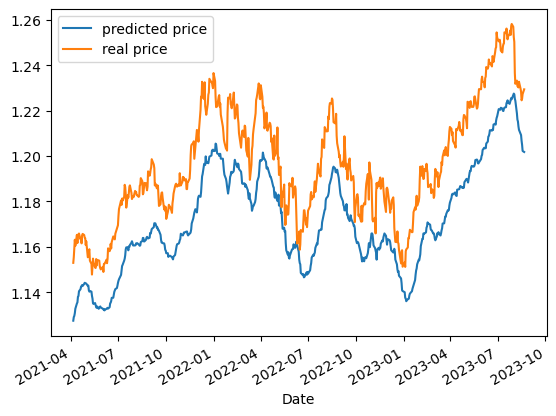

In [34]:
y_pred_test[company_test]\
    .reset_index(level=1)\
    ["price"]\
    .plot(
        label = "predicted price"
    )

y_test[company_test]\
    .reset_index(level=1)\
    ["price"]\
    .plot(
        label = "real price"
    )

# y_test[(y_pred_test.pct_change() < 0 ) & (y_test.index.get_level_values("ticker") == "AAPL")]\
#     .reset_index(level= "ticker")\
#     ["price"]\
#     .plot(
#         label = "buy",
#         marker = "^",
#         linestyle = "None",
#         color = "green"
#     )

# y_test[(y_pred_test.pct_change()>0 ) & (y_test.index.get_level_values("ticker") == "AAPL")]\
#     .reset_index(level= "ticker")\
#     ["price"]\
#     .plot(
#         label = "sell",
#         marker = "^",
#         linestyle = "None",
#         color = "red"
#     )

plt.legend()

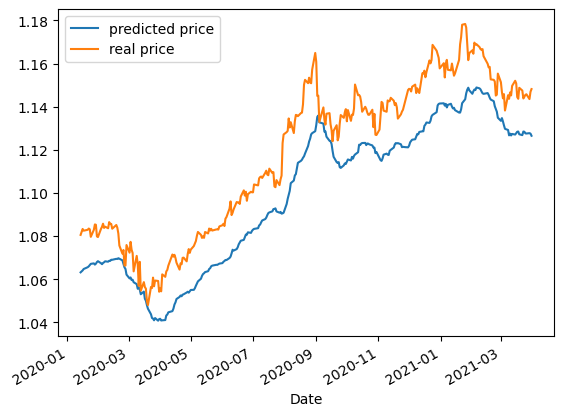

In [35]:
# plt.figure(figsize = (16,10))

y_pred_train[company_train]\
    .reset_index(level= "ticker")\
    ["price"]\
    .plot(
        label = "predicted price",
        # color = "blue"
    )

y_train[company_train]\
    .reset_index(level= "ticker")\
    ["price"]\
    .plot(
        label = "real price",
        # color = "blue"
    )




plt.legend()

## Creating signal

## PnL

In [36]:
y_pred_test.index.get_level_values("Date") > "2023"

array([False, False, False, ...,  True,  True,  True])

In [90]:
train = False
only_2023= False
num_trades = {}

pnls = {}

for ticker in tqdm(universe):
    company_train = y_pred_train\
        .index\
        .get_level_values("ticker") == ticker


    company_test = y_pred_test\
        .index\
        .get_level_values("ticker") == ticker
    
    if not train:
        y_company = y_test[company_test]
        y_pred_company = y_pred_test[company_test]

    else:
        y_company = y_train[company_train]\
            .sort_index(level = "Date")
        y_pred_company = y_pred_train[company_train]\
            .sort_index(level = "Date")
        

    if only_2023:
        idx = y_company\
            .index\
            .get_level_values("Date") > "2023"
        
        y_company = y_company[idx]
        y_pred_company = y_pred_company[idx]

    avg_price = y_pred_company\
        .pct_change()\
        .rolling(20)\
        .mean()

    std_price = y_pred_company\
        .pct_change()\
        .rolling(20)\
        .std()
    
    zscore = (y_pred_company.pct_change() - avg_price)/std_price

    positions = pd.Series(
        np.nan,
        index = y_pred_company.index,
        name = "position"
    )
    
    positions.loc[y_pred_company.pct_change() < 0]  = 1
    positions.loc[y_pred_company.pct_change() > 0] = -1 


    positions = positions\
        .fillna(0)
    
    num_long = (positions == 1).sum()/positions.shape[0]
    num_short = (positions == -1).sum()/positions.shape[0]

    num_trades[ticker] = {
        "num_long" : num_long,
        "num_short" : num_short
    }
    
    positions_df = pd.concat([y_company, positions], axis = 1)

    positions_df = positions_df\
        .reset_index(level = "ticker")

    pnl = pd.Series(
        0,
        index = positions_df.index,
        name = "pnl"
    )

    last_buy_price = np.nan
    cash = 0
    position = 0 

    for date, row in positions_df.iterrows():
        first_trade = np.isnan(last_buy_price) and row["position"] != 0 
        has_position = not np.isnan(last_buy_price) and position != 0
        changing_position = has_position and row["position"] != position
        holding_position = has_position and row["position"] == position

        if (first_trade):
            last_buy_price = row["price"] 
            position = row["position"]

        if (changing_position):
            cash += (row["price"] / last_buy_price - 1 )*position
            # last_buy_price = np.nan
            position = row["position"]
            
            if (position == 0):
                last_buy_price = np.nan
            else:
                last_buy_price = row["price"] 

        if holding_position:
            pnl.loc[date] = (row["price"]- last_buy_price)/last_buy_price * position + cash

        else:
            pnl.loc[date] = cash

    if row["position"] != 0:
        cash += (row["price"]- last_buy_price)/last_buy_price * position

        pnl.loc[date] = cash

    pnls[ticker] = pnl
        

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 11.49it/s]


In [91]:
num_trades

{'AMZN': {'num_long': 0.49, 'num_short': 0.5083333333333333},
 'AAPL': {'num_long': 0.4533333333333333, 'num_short': 0.545},
 'MSFT': {'num_long': 0.49833333333333335, 'num_short': 0.5},
 'TSLA': {'num_long': 0.485, 'num_short': 0.5133333333333333},
 'FB': {'num_long': 0.49333333333333335, 'num_short': 0.505},
 'NFLX': {'num_long': 0.48833333333333334, 'num_short': 0.51},
 'GOOGL': {'num_long': 0.44, 'num_short': 0.5583333333333333},
 'ORCL': {'num_long': 0.4533333333333333, 'num_short': 0.545},
 'ADBE': {'num_long': 0.49166666666666664, 'num_short': 0.5066666666666667},
 'NVDA': {'num_long': 0.48, 'num_short': 0.5183333333333333}}

In [92]:
(positions == 1).sum()/positions.shape[0]

0.48

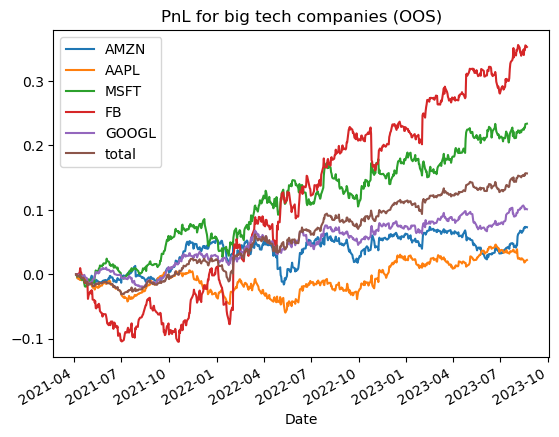

In [93]:
pnl_total = pd.Series(
    0,
    index = pnls["AAPL"].index
)
for k, pnl in pnls.items():
    # if k == "ADBE" or k == "ORCL":
    #     continue

    if k not in ["AAPL", "GOOGL", "FB", "AMZN", "MSFT"]:
        continue

    pnl.plot(
        label = k
    )


    pnl_total += pnl

(pnl_total/5).plot(
    label = "total",
)

plt.title("PnL for big tech companies (OOS)")
plt.legend()

In [95]:
(pnl_total.diff().mean())/pnl_total.diff().std() * np.sqrt(252)

1.3037882380367847

## Correlation with tech index

In [61]:
prices_df = yf.download(
    tickers= "IVV",
    start="2019-12-30",
    end="2023-12-30",
)

[*********************100%***********************]  1 of 1 completed


In [62]:
returns_etf = prices_df["Close"]\
    .pct_change()\
    .reindex(index= pnl.index)

In [63]:
(pnl_total.diff() - returns_etf).mean() / pnl_total.diff().std() * np.sqrt(252)

1.103580733153526

In [64]:
prices_df["Close"].reindex(index = pnl_total.index).corr(pnl_total)

-0.381977409637153

In [67]:
scaler = MinMaxScaler((0,1))
prices_close = scaler.fit_transform(prices_df[["Close"]])
# normalized_pnl = scaler.fit_transform(pd.DataFrame(pnl_total))

<Axes: xlabel='Date'>

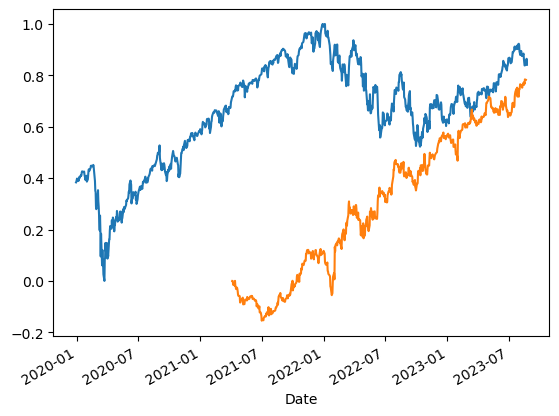

In [69]:
pd.Series(
    prices_close.reshape(-1),
    index = prices_df.index
).plot()
pnl_total.plot()